# Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

# Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

# Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

# Data Dictionary

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

# Data Overview

In [2]:
bank = pd.read_excel("Credit Card Customer Data.xlsx")

In [3]:
df = bank.copy()

In [4]:
df.shape

(660, 7)

In [5]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


- The dataset consists of 660 rows and 7 columns. All columns are integers.
- Column name `Customer Key` needs to be fixed.

**Fix column name**

In [7]:
df.rename(columns = {"Customer Key": "Customer_Key"}, inplace = True)

**Check missing values**

In [8]:
df.isnull().sum()

Sl_No                  0
Customer_Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- No missing values.

**Check unique values**

In [9]:
df.nunique()

Sl_No                  660
Customer_Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

- `Sl_No` is the Primary key of the records. It has 660 unique values, that means it would no provide any information for our clustering.
- `Customer_Key` is Customer identification number. It would not be used for the clustering. However, it only has 655 unique values, indicating duplicate customer key.

In [10]:
df.loc[df.duplicated(subset = "Customer_Key"), "Customer_Key"].values

array([47437, 96929, 37252, 50706, 97935])

- Five Customer Keys are repeated. Check these obserevations.

In [11]:
duplicate_keys = [47437, 96929, 37252, 50706, 97935]
df[df.Customer_Key.isin(duplicate_keys)].sort_values(by = "Customer_Key")

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


- Observations with identical `Customer_Key` have totally different Average Credit Limit/ Total credit cards/ Total visits bank/ Total visits online/ Total calls made.

**Combine duplicate records.**

In [12]:
attribute_cols = df.columns.to_list()[2:]   # attibute column to combine
idx = df[df.Customer_Key.isin(duplicate_keys)].sort_values(by = "Customer_Key").index  # index of duplicate rows

for i in range(0, len(idx), 2):
    for col in attribute_cols:
        df.loc[idx[i], col] += df.loc[idx[i + 1], col]   # merge the latter record to the first one
        
df = df.drop(index = [432, 332, 541, 398, 632])   # keep the first occurrence
df[df.Customer_Key.isin(duplicate_keys)].sort_values(by = "Customer_Key")  # check duplicates again

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,65000,10,2,3,10
4,5,47437,117000,13,3,13,3
411,412,50706,104000,11,10,2,4
391,392,96929,80000,10,7,2,2
104,105,97935,204000,9,2,9,10


**Drop `Sl_No` column**

In [13]:
df = df.drop(columns = "Sl_No")

**Check data description**

In [14]:
df.describe()

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,55058.158779,34838.167939,4.741985,2.421374,2.625954,3.610687
std,25606.965469,38000.419397,2.229012,1.657944,2.952571,2.869678
min,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,33623.500000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,53898.000000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,77084.500000,48500.000000,6.000000,4.000000,4.000000,5.000000
max,99843.000000,204000.000000,13.000000,10.000000,15.000000,10.000000


- `Avg_Credit_Limit` is right skewed and has a wide range from 3000 to 204000.
- The remaining columns have similar range and almost equal mean and median.

# Univariate Analysis

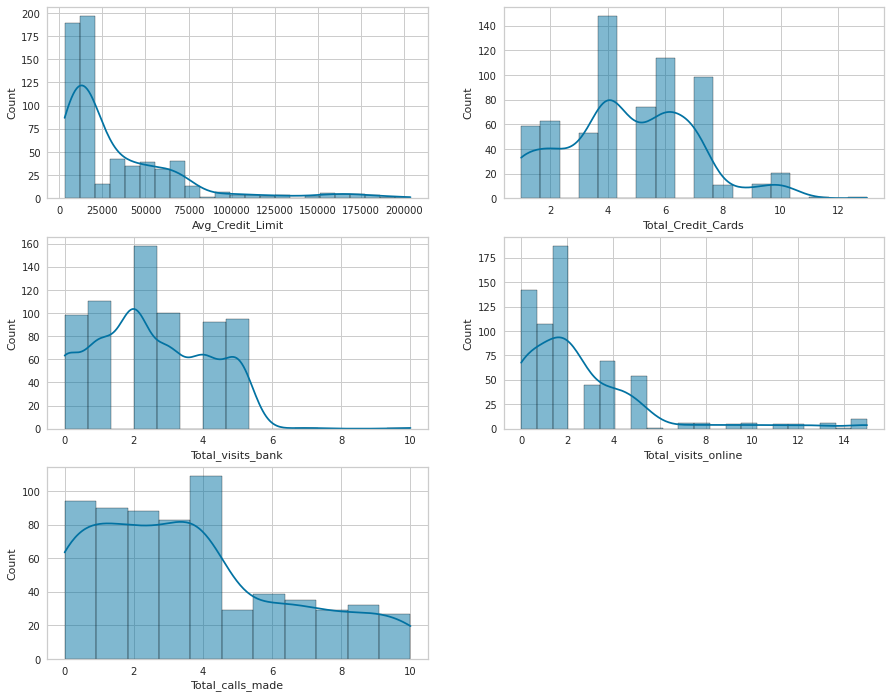

In [19]:
plt.figure(figsize = (15,12))
for i,col in enumerate(attribute_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df[col], kde = True);

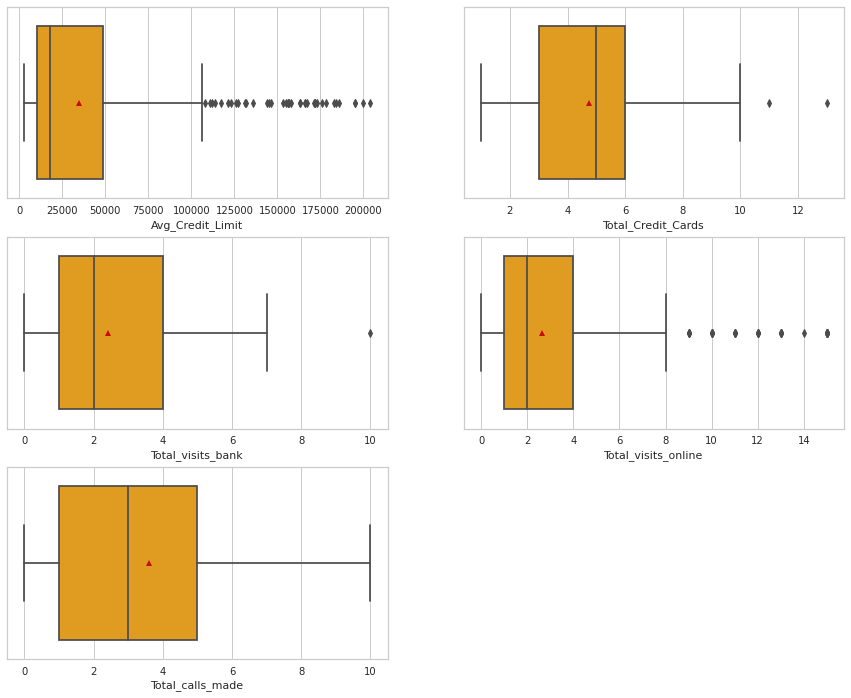

In [21]:
plt.figure(figsize = (15,12))
for i,col in enumerate(attribute_cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x = col, data = df, showmeans = True, color = "orange");

- Most customers get credit limit less than 25000. Lots of outliers on the right side.
- All customers have at least one credit card. On average five credit cards per customer. Most customers have no more than six credit cards. 
- Most customers visit the bank personally less than six times yearly. Some never visit the bank.
- Most customers login the bank's website less than four times yearly. Some never use the online service. However there're also a bunch of customers login as frequently as 12+ times yearly.
- Most customers call the bank no more than four times yearly. Some of them never call.